In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")
import scienceplots

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge, measure_pce
from best_subset import *
from frols import frols
from UBIC import *
from solvel0 import solvel0
from findiff import FinDiff
import sgolay2

from knockpy import KnockoffFilter
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Sklearn's version: 1.6.1


#### Load data

In [2]:
n = 128
data = sio.loadmat(f"../Datasets/Big/reaction_diffusion_3d_{n}.mat")
u_sol = np.array((data['usol']).real, dtype=np.float32)
v_sol = np.array((data['vsol']).real, dtype=np.float32)
x = np.array((data['x'][0]).real, dtype=np.float32)
y = np.array((data['y'][0]).real, dtype=np.float32)
z = np.array((data['z'][0]).real, dtype=np.float32)
t = np.array((data['t'][0]).real, dtype=np.float32)

del data

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

# Ground truth
ground_indices_u = (0, 1, 8, 12, 18, 26)
ground_coeff_u = np.array([0.014, -0.014, -1.000, 0.020, 0.020, 0.020])
ground_indices_v = (2, 8, 13, 19, 27)
ground_coeff_v = np.array([-0.067, 1.0, 0.01, 0.01, 0.01])

In [3]:
u = np.zeros((n, n, n, len(t), 2))
u[:, :, :, :, 0] = u_sol
u[:, :, :, :, 1] = v_sol
del u_sol, v_sol

# Add noise
np.random.seed(100)
noise_lv = 0.1
domain_noise = 0.01*np.abs(noise_lv)*np.std(u)*np.random.randn(*u.shape)
u = u + domain_noise

#### Denoise

In [4]:
denoise = True
if denoise: 
    un = u[:, :, :, :, 0]
    vn = u[:, :, :, :, 1]

    div = 30
    ws = max(un.shape[:-2])//div; po = 5
    if ws%2 == 0: ws -=1

    nun = np.zeros_like(un)
    for i in trange(un.shape[-1]):
        for j in range(un.shape[-2]):
            nun[:, :, j, i] = sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(un[:, :, j, i])
    un = nun.copy()
    del nun
    
    nvn = np.zeros_like(vn)
    for i in trange(vn.shape[-1]):
        for j in range(vn.shape[-2]):
            nvn[:, :, j, i] = sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(vn[:, :, j, i])
    vn = nvn.copy()
    del nvn
    
    dim = 10

    un = un.reshape(-1, len(t))
    uun, sigmaun, vun = np.linalg.svd(un, full_matrices=False); vun = vun.T
    un = uun[:,0: dim].dot(np.diag(sigmaun[0:dim]).dot(vun[:,0:dim].T))
    un = un.reshape(len(x), len(y), len(z), len(t))

    vn = vn.reshape(-1, len(t))
    uvn, sigmavn, vvn = np.linalg.svd(vn, full_matrices=False); vvn = vvn.T
    vn = uvn[:,0: dim].dot(np.diag(sigmavn[0:dim]).dot(vvn[:,0:dim].T))
    vn = vn.reshape(len(x), len(y), len(z), len(t))

    u = np.stack([un, vn], axis=-1)
    del un, vn, uun, uvn

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.64it/s]


#### Applying best-subset regression on the weak formulation

In [5]:
# Need to define the 2D spatial grid before calling the library
# X, Y, Z, T = np.meshgrid(x, y, z, t, indexing="ij")
spatiotemporal_grid = np.asarray(np.meshgrid(x, y, z, t, indexing="ij"))
spatiotemporal_grid = np.transpose(spatiotemporal_grid, axes=[1, 2, 3, 4, 0])
weak_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=3,include_bias=False),
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    is_uniform=True,
    include_interaction=False,
    include_bias=True,
    periodic=True,
    K=5000,
)

In [6]:
# X_pre = np.array(weak_lib.fit_transform(u), dtype=np.float32)
# y_pre = np.array(weak_lib.convert_u_dot_integral(u), dtype=np.float32)
# np.save("X_weak_GS_2025.npy", X_pre)
# np.save("y_weak_GS_2025.npy", y_pre)
X_pre = np.load("X_weak5000_GS_2025.npy")
y_pre = np.load("y_weak5000_GS_2025.npy")
u_pre, v_pre = y_pre[:, 0:1], y_pre[:, 1:2]
del y_pre
feature_names = np.load("feature_names_GS.npy").astype(object)

### Knockoffs ###

In [7]:
X_scale = StandardScaler().fit_transform(X_pre)
u_scale = u_pre-u_pre.mean()

kfilter = KnockoffFilter(
    ksampler='gaussian',
    fstat='ols',
    knockoff_kwargs={'method':'mvr'}
)

fdr = 0.1; n_interation = 50
rejections_u = []
for _ in trange(n_interation):
    rejections = kfilter.forward(X=X_scale, y=u_scale.flatten(), fdr=fdr, shrinkage="ledoitwolf")
    rejections = set(np.where(rejections == 1)[0])
    if len(rejections) > 0:
        rejections_u.append(rejections)
rejections_u = sorted(set.intersection(*rejections_u))
print(rejections_u, ground_indices_u)
X_u = X_pre[:, rejections_u]

100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.04it/s]

[0, 1, 8, 12, 18, 26] (0, 1, 8, 12, 18, 26)


In [8]:
X_scale = StandardScaler().fit_transform(X_pre)
v_scale = v_pre-v_pre.mean()

kfilter = KnockoffFilter(
    ksampler='gaussian',
    fstat='ols',
    knockoff_kwargs={'method':'mvr'}
)

fdr = 0.1; n_interation = 50
rejections_v = []
for _ in trange(n_interation):
    rejections = kfilter.forward(X=X_scale, y=v_scale.flatten(), fdr=fdr, shrinkage="ledoitwolf")
    rejections = set(np.where(rejections == 1)[0])
    if len(rejections) > 0:
        rejections_v.append(rejections)
rejections_v = sorted(set.intersection(*rejections_v))
print(rejections_v, ground_indices_v)
X_v = X_pre[:, rejections_v]

100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.14it/s]

[2, 8, 13, 17, 19, 27] (2, 8, 13, 19, 27)


In [9]:
_, best_subsets_u = brute_force_all_subsets(X_u, u_pre)
_, best_subsets_v = brute_force_all_subsets(X_v, v_pre)

100%|████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 288.97it/s]


#### Model selection by the UBIC (Algorithm 1)

In [10]:
tau = 3; per = 75 # 85
scale = np.log(len(u_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_u, (X_u, u_pre), 
                                               u_type='cv1', take_sqrt=True)
predictions = X_u@post_means

b_bics = np.array(b_bics)
b_bics_u = b_bics
complexities = np.array([len(bs) for bs in best_subsets_u])
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_u):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], u_pre)/np.log(len(u_pre))-com
    lower_bound = 2*log_like_value(predictions[:, k:k+1], u_pre)-np.log(len(u_pre))*com
    lower_bounds.append(lower_bound)
    
last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 10)
last_lam_d_u = last_lam
last_ubic_d_u = last_ubic
last_bc_d_u = last_bc
uns_u = b_uns
last_lam, last_ubic, last_bc

0.13764452422116064
5 <---> 5 inf
5 <---> 5 inf


(1.421928999,
 array([ -84546.75427496,  -82183.05349421,  -95557.7230581 ,
        -122336.85422546, -134582.56111342, -156841.45203514]),
 5)

In [11]:
tau = 3; per = 75 # 85
scale = np.log(len(v_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_v, (X_v, v_pre), 
                                               u_type='cv1', take_sqrt=True)
predictions = X_v@post_means

b_bics = np.array(b_bics)
b_bics_v = b_bics
complexities = np.array([len(bs) for bs in best_subsets_v])
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_v):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], v_pre)/np.log(len(v_pre))-com
    lower_bound = 2*log_like_value(predictions[:, k:k+1], v_pre)-np.log(len(v_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 10)
last_lam_d_v = last_lam
last_ubic_d_v = last_ubic
last_bc_d_v = last_bc
uns_v = b_uns
last_lam, last_ubic, last_bc

0.13061711741205684
4 <---> 4 inf
4 <---> 5 8.991454340801285e-05


(2.8548246721,
 array([ 846226.66302194, 1513824.41768947,  642360.3947097 ,
          65602.70902164, -157032.80625386, -156772.99528299]),
 4)

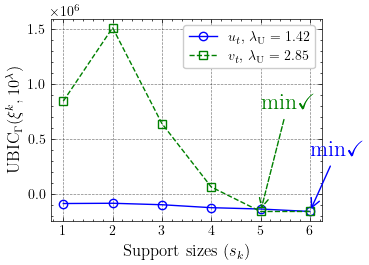

In [13]:
# assert list(map(len, best_subsets_u)) == list(map(len, best_subsets_v))
complexities_u = list(map(len, best_subsets_u))
complexities_v = list(map(len, best_subsets_v))
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot(complexities_u, last_ubic_d_u, 'o-', c='blue', markerfacecolor='none', label="$u_t,\, \lambda_{\\textrm{U}}=$ "+str(round(last_lam_d_u, 2)))
    ax.plot(complexities_v, last_ubic_d_v, 's--', c='green', markerfacecolor='none', label="$v_t,\, \lambda_{\\textrm{U}}=$ "+str(round(last_lam_d_v, 2)))
    ax.set_xticks(complexities)
    ax.set_ylabel("$\\textrm{UBIC}_{\\Gamma}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)

    plt.annotate('min$\checkmark$', fontsize=16, c='blue', 
             xy=(complexities_u[last_bc_d_u], last_ubic_d_u[last_bc_d_u]), 
             xytext=(complexities_u[last_bc_d_u], last_ubic_d_u[last_bc_d_u]+0.5e6), 
             arrowprops={'arrowstyle': '->', 'linestyle':'-', 'color':'blue'})
    
    plt.annotate('min$\checkmark$', fontsize=16, c='green', 
             xy=(complexities_v[last_bc_d_v], last_ubic_d_v[last_bc_d_v]), 
             xytext=(complexities_v[last_bc_d_v], last_ubic_d_v[last_bc_d_v]+0.925e6), 
             arrowprops={'arrowstyle': '->', 'linestyle':'--', 'color':'green'})
    
    plt.legend()
    plt.show()

#### Percent coefficient error

In [14]:
errs_u = measure_pce(np.linalg.lstsq(X_u[:, best_subsets_u[last_bc_d_u]], u_pre, rcond=None)[0].flatten(), 
                     ground_coeff_u)
errs_v = measure_pce(np.linalg.lstsq(X_v[:, best_subsets_v[last_bc_d_v]], v_pre, rcond=None)[0].flatten(), 
                     ground_coeff_v)
print(errs_u.mean(), errs_u.std())
print(errs_v.mean(), errs_v.std())

0.07932984403201548 0.1376675092222184
0.002098426000397427 0.0017979140746648423


In [20]:
from bayesian_model_evidence import log_evidence
from kneefinder import KneeFinder

def knee_finder(y, decreasing=False):
    y = np.array(y)
    if decreasing:
        decreasing_indices = range(0, len(y))
    else:
        decreasing_indices = decreasing_values_indices(y)
    if len(decreasing_indices) == 2 and y[1] < y[0]:
        return 1
    kf = KneeFinder(decreasing_indices, y[decreasing_indices])
    return int(kf.find_knee()[0])

v = 1e-2
while 1:
    bme = [log_evidence(X_u, u_pre, effective_indices=bs, v=v) for bs in best_subsets_u]
    if np.argmax(bme) >= knee_finder(b_bics_u):
        break
    else:
        v *= 10
print(bme, np.argmax(bme)) # does not yield the governing eq.
print()

v = 1e-2
while 1:
    bme = [log_evidence(X_v, v_pre, effective_indices=bs, v=v) for bs in best_subsets_v]
    if np.argmax(bme) >= knee_finder(b_bics_v):
        break
    else:
        v *= 10
print(bme, np.argmax(bme)) # does not yield the governing eq.

[1377.986572763099, 1377.9865759880972, 1377.986578809356, 1377.9865797702516, 1377.98657981262, 1377.9865798171386] 5

[1377.9865756123534, 1377.9865766488642, 1377.9865792447654, 1377.9865797866075, 1377.9865798168478, 1377.9865798152646] 4
